# Análisis de opinión en textos

# 1. Introducción

Vamos a construir un modelo de clasificación a partir de 50000 comentarios sobre películas subidos a *Internet Movie Data Base*, y que están almacenados en archivos de texto. Este modelo deberá ser capaz de predecir si un nuevo comentario es positivo o negativo.

Para poder entrenar un clasificador a partir de un conjunto de documentos de texto, es necesario representar datos en una matriz bidimensional. En el modelo *Bag of Words*, cada documento se representa a partir del conjunto de palabras que aparece en él. Previamente a construir la matriz de datos, elaboraremos un vocabulario con la unión de todos los términos que aparecen en algún momento en el documento.

En la versión más básica, cada posición (*d*,*t*) de la matriz contiene el valor para la medida ***Term Frequency***, que se denota *$t f_{d,t}$*, y refleja el número de veces que aparece el término *t* en el documento *d*.

Una vez se dispone de la representación en forma matricial, y puesto que se cuenta con el conjunto de valoraciones asociadas a cada revisión (aprendizaje supervisado), es posible coinstruir un modelo de clasificación. Este dependerá de la representación utilizada. Así, si se utiliza *t fid*$f_{d,t}$ se pueden utilizar métodos como regresión logística o SVM. En el caso de utilizar la aparición o no de cada término en la posición (d, t) de la matriz, se pueden utilizar otro métodos como *Naive Bayes*.

Éste es el modelo más básico de análisis de opinión, pero existen modelos más complejos y refinados. Por otra parte, en muchos casos la diferencia en resultados no se debe solamente al clasificador elegido, sino del preprocesamiento que se haga sobre los textos, o a otros factores como el uso de n-gramas o POS tagging. Aquí, el preprocesamiento será sencillo, consitente en eliminar etiquetas HTML, caracteres no alfabéticos y reducir palabras a su raíz.

## Importamos librerías que vamos a utilizar

In [29]:
import numpy as np
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%config InlineBackend.figure_format='retina'
%matplotlib inline

sns.set()

# 2. Recogida de datos

Procesar miles de documentos requiere tiempo. Debido a esto, es conveniente utilizar un subconjunto durante la implementación y pruebas. La variable `num_docs`, definida a continuación, fija el tamaño de entrenamiento y test con el que trabajar. El máximo valor que puede tomar es 25000.

In [2]:
num_docs = 5000 # Cambiar por 25000 para verificar en todo el conjunto del dataset

Cargamos los datos del archivo `Data/datos_peliculas_train.csv` en un DataFrame `df_reviews`.

También sería necesario desordenar los datos, ya que están ordenados por clase y, bien al seleccionar un subconjunto para pruebas, o posteriormente al dividir el conjunto en entrenamiento/validación, todos los casos correspondientes a una partición podrían corresponder a la misma clase.

In [3]:
np.random.seed(0)

df_reviews = pd.read_csv('Data/datos_peliculas_train.csv')

df_reviews = df_reviews.sample(frac=1).reset_index(drop=True)

df_reviews = df_reviews.iloc[:num_docs, :]

df_reviews

,review,sentiment
0,Went to watch this movie expecting a 'nothing ...,0
1,This movie is wonderful. What separates it fro...,1
2,"I guess I've seen worse films, but that may be...",0
3,"If you like CB4, you have no idea what you're ...",1
4,"Expecting to see a ""cute little film"" from mai...",1
...,...,...
4995,This is a good film for 99% of the duration. I...,1
4996,(aka: BLOOD CASTLE or SCREAM OF THE DEMON)<br ...,0
4997,While essentially a remake of the original Chi...,1
4998,From the start I knew I would be in for the be...,1


Cargamos los datos del archivo `Data/datos_peliculas_test.csv` en un DataFrame `df_new_reviews`. Y volvemos a seleccionar los `num_docs` primeros casos e, igual que el caso anterior, desordenar el DataFrame.

Estos datos solo los vamos a utilizar para evaluar el rendimiento del modelo final.

In [4]:
df_new_reviews = pd.read_csv('Data/datos_peliculas_test.csv')

df_new_reviews = df_new_reviews.sample(frac=1).reset_index(drop=True)

df_new_reviews = df_new_reviews.iloc[:num_docs, :]

df_new_reviews

,review,sentiment
0,"Okay, I like to give the benefit of the doubt....",0
1,I remember seeing this film when I was 13 year...,1
2,<br /><br />This movie really has nothing goin...,0
3,This movie was better than I expected. I don't...,1
4,A formulaic story with all the tired cliches. ...,0
...,...,...
4995,Great job! Was very exciting and had great stu...,1
4996,It's particularly hard for a director to captu...,1
4997,"This film, which I rented under the title ""Bla...",0
4998,"When, oh when, will Hollyweird write a decent ...",0


# 3. Preparación de datos

Una vez recogidos los datos, y almacenados en un formato adecuado, se procede a la creación de un conjunto de entrenamiento de tipo *Bag of Words* en el que cada revisión se representará mediante una lista de términos y su clase. En primer lugar, han de limpiarse los datos, es decir, eliminar etiquetas HTML y los signos. Para lo que se van a crear varias funciones y, después, se convertirá cada cadena de texto en una lista de términos relevantes.

## 3.1 Eliminación de etiquetas HTML

Por lo general, las etiquetas HTML introducen información innecesaria en el modelo *Bag of Words*, por lo que es conveniente eliminarlas.

Vamos a implementar una función `removeHTML()`, que tome como parámetro una cadena de texto, elimina las etiquetas de esta y devuelva una nueva cadena. Para desarrollarla vamos a apoyarnos en las expresiones regulares.

In [5]:
def removeHTML(text):
    text = re.sub('<[^>]*>', '', text)
    return text

## 3.2 Eliminación de caracteres no alfabéticos (Excepto emoticonos)

Los caracteres no alfabéticos tampoco son relevantes en el modelo *Bag of Words*. Sin embargo, en este contexto sí que pueden serlo los emoticonos, ya que contienen información relevante con respescto a la valoración que se hace en los comentarios.

Vamos a implementar una función `clean()`, que tome como parámetro una cadena de texto y elimine de esta los caracteres que no correspondan a palabras, excluyendo los emoticonos. Para esto, vamos a detectar y guardar emoticonos, eliminar los caracteres no alfabéticos y, finalmente, añadir al resultado los emoticonos detectados en el primer paso.

También será necesario utilizar expresiones regulares. Vamos a considerar que los emoticonos se componen de tres partes: ojos, que pueden ser uno de estos tres caracteres {`:` `;` `=`}, boca que puede ser {`)` `(` `D` `P`} y, opcionalmente, nariz {`-`}.
Se trata de construir una expresión regular que encuentre una sucesión de estos tres elementos.

In [6]:
def clean(text):
    # Guardamos los emoticonos
    emoticons = re.findall('(?::|;|=)(?:-?)(?:\)|\(|D|P)', text)
    
    # Eliminamos los caracteres no alfabeticos
    text = re.sub('[\W]+', ' ', text.lower())
    text = re.sub('[\d]+', '', text.lower())
    
    # Añadir los emotcionos, eliminando '-'
    text = text + ' '.join(emoticons).replace('-', '')
    
    return text

# 4. Elaboración de la lista de palabras relevantes

En el siguiente paso del preprocesamiento consiste en elaborar una lista de palabras. Una opción es dividir la cadena de texto con el método `split()`. Pero es recomendable seguir unos pasos adicionales. Por ejemplo, existen palabras que no proporcionan ninguna información y que es mejor eliminar, las *stopwords*, y que podemos tratar con la librería NLTK.

In [7]:
stopwords_eng = stopwords.words('english')
print(stopwords_eng)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Por otra parte, las cadenas "gusta" y "gustó" son distintas, por lo que también se considerarían palabras distintas. Esto podría repercutir en una degradación del rendimiento del modelo. Existen dos técnicas que permiten agrupar palabras por familias:
 - `Stemming`: Consiste en reducir cada palabra a su raíz.
 - `Lematización`: Consiste en reemplazar cada palab ra por su lema que, en el ejemplo, sería "gustar".

In [8]:
stemmer = PorterStemmer()

Vamos a crear una función `extracTerms()` que toma por parámetro una cadena de caracteres y que devuelva la lista de términos correspondiente, descartandos las *stopwords* y sustituyendo cada palabra por su raíz. 

La descomposición de la cadena en palabras puede hacerse con el método `split()`. Sin embargo, es preferible utilizar la función `word_tokenize()`.

In [9]:
def extracTerms(text):
    word_list = [w for w in word_tokenize(text) if w not in stopwords_eng]
    
    word_list = [stemmer.stem(word) for word in word_list]
    
    return word_list

La función `PorterStemmer` devuelve excepciones en algunos casos. Parece que utilizando solamente 5000 casos no hay problema. Sin embargo, sí que lo hay con algún caso concreto que aparece después. Por tanto, se recomienda comentar la línea correspondiente si se utiliza un número mayor de ejemplos. Como consecuencia, el vocabulario crecerá bastante.

# 5. Preprocesamiento del conjunto de datos

Una vez implementadas las funciones, se procederá al preprocesamiento de datos.

Procesar los datos del DataFrame `df_reviews` con los métodos indicados aplicando sucesivamente las funciones `removeHTML()` y `clean()` sobre el campo `review`.

In [10]:
df_reviews['review'] = df_reviews['review'].apply(removeHTML)
df_reviews['review'] = df_reviews['review'].apply(clean)

# 6. Representación de datos mediante matriz TF-IDF

Con los datos ya limpios, vamos a construir un conjunto de entrenamiento a partir de la representación *Bag of Words*. Para ello, vamos a utilizar el objeto `TfidfVectorizer`. El método `TfidfVectorizer.fit()` recibe el conjunto de documentos, y genera un vocabulario con todos los términos que aparecen en él. Éste será almacenado en un campo, `vocabulary_`, que es un diccionario en el que las claves corresponden a cada uno de los términos, y los valores a su índice.
También almacena otros parámetros necesarios para el cálculo de la métrica, como el número de documentos en los que aparece cada término. Por otra parte, una vez creado el vocabulario, el método `transform()` recibe un conjunto de documentos y genera la matriz de datos en la que la posición (d, t) contiene el valor tf - id$f_{d,t}$. En este caso, que se van a utilizar los mismos documentos para instanciar el objeto y crear la matriz, se puede llamar directamente al método `fit_transform()`, lo que equivale a llamar secuencialmente a los dos anteriores.

El objeto `TfidfVectorizer` acepta un parámetro `tokenizer`, mediante el que se puede pasar una función para llevar a cabo la descomposición de la cadena de caracteres en términos. En este caso, vamos a pasar la función `extractTerms()`.<br>
También se va a utilizar otro parámetro de interés, denominado `ngram_range` que permite que, además de términos, se consideren n-gramas o secuencia de términos.

**Objetivo**: Construir un objeto de la clase `TfidfVectorizer`, transformar la columna review en una matriz de datos que será almacenada en una variable e imprimir el vocabulario.

In [11]:
tfidf_vec = TfidfVectorizer(tokenizer=extracTerms,
                            ngram_range=(1,1))
tfidf_reviews = tfidf_vec.fit_transform(df_reviews['review'])

print('Tamaño vocabulario: ', len(tfidf_vec.vocabulary_))

Tamaño vocabulario:  26340


Vamos a aprovechar también para crear los arrays con los datos por legibilidad.

In [12]:
X = tfidf_reviews
y = df_reviews['sentiment'].values

# 7. Aprendizaje de un modelo de regresión logística

## 7.1 Ajuste del parámetro de regularización mediante selección de modelos

Disponiendo del conjunto de datos y con objetivo de ajustar los parámetros del modelo, vamos a hacer la división en dos partes con el método `train_test_split`.<br>
El 75% de los datos se utilizarán para entrenamiento, y las variables de entrada y salida se guardarán en las variables `X_train`e `y_train`, respectivamente. El resto de datos se dedicarán a la validación, almacenadas en las variables `X_val` e `y_val`.

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.25)

In [14]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(3750, 26340) (3750,) (1250, 26340) (1250,)


Vamos a aprender un modelo de regresión logística, almacenado en `lr_model`, con los datos de entrenamiento `X` e `y` y verificaremos el acierto sobre ese conjunto de entrenamiento. <br>
Se fijará el parámetro C = 10 (representa la inversa de la regularización, es decir, **C = $\frac{1}{\lambda}$**

In [15]:
lr_model = LogisticRegression(C=10,
                              random_state=42)
lr_model.fit(X_train,
             y_train)

print('Acierto (Entrenamiento): {} '.format(lr_model.score(X_train, y_train)))
print('Acierto (Validación): {} '.format(lr_model.score(X_val, y_val)))

Acierto (Entrenamiento): 0.9986666666666667 
Acierto (Validación): 0.8464 


Tras utilizar un valor arbitrario para el parámetro C. Vamos a implementar un método de selección de modelos para determinar el valor óptimo para el parámetro de regularización. Se van a probar valores desde $10^{-5}$ a $10^{5}$.

In [16]:
c_range = np.logspace(-5, 5, 11)
best_score = 0
C_b  = 0

for C in c_range:
    lr_model.set_params(C=C)
    lr_model.fit(X_train, y_train)
    train_score, val_score = lr_model.score(X_train, y_train), lr_model.score(X_val, y_val)
    if val_score > best_score:
        best_score = val_score
        C_b = C
    
    print("C=%e \t Entrenamiento: %.3f / Validación %.3f " % (C, train_score, val_score))
    
print("\nValor óptimo para el parámetro de regularización: ", C_b)

C=1.000000e-05 	 Entrenamiento: 0.506 / Validación 0.486 
C=1.000000e-04 	 Entrenamiento: 0.506 / Validación 0.486 
C=1.000000e-03 	 Entrenamiento: 0.506 / Validación 0.486 
C=1.000000e-02 	 Entrenamiento: 0.817 / Validación 0.746 
C=1.000000e-01 	 Entrenamiento: 0.882 / Validación 0.822 
C=1.000000e+00 	 Entrenamiento: 0.955 / Validación 0.850 
C=1.000000e+01 	 Entrenamiento: 0.999 / Validación 0.846 
C=1.000000e+02 	 Entrenamiento: 1.000 / Validación 0.836 
C=1.000000e+03 	 Entrenamiento: 1.000 / Validación 0.834 
C=1.000000e+04 	 Entrenamiento: 1.000 / Validación 0.830 
C=1.000000e+05 	 Entrenamiento: 1.000 / Validación 0.829 

Valor óptimo para el parámetro de regularización:  1.0


In [17]:
lr_model = LogisticRegression(C=C_b,
                              random_state=42)
lr_model.fit(X_train,
             y_train)

print('Acierto (Entrenamiento): {} '.format(lr_model.score(X_train, y_train)))
print('Acierto (Validación): {} '.format(lr_model.score(X_val, y_val)))

Acierto (Entrenamiento): 0.9546666666666667 
Acierto (Validación): 0.8496 


## 7.2 Ajuste del parámetro de regularización mediante selección de modelos

La selección del parámetro C también puede hacerse mediante `GridSearchCV`. En este caso no haría falta dividir X en train/test, ya que utiliza validación cruzada.

In [18]:
from sklearn.model_selection import GridSearchCV

lf_model = GridSearchCV(LogisticRegression(random_state=42),
                        param_grid={"C":np.logspace(-5, 5, 11)},
                        cv=5)

lf_model.fit(X, y)

print(lf_model.best_params_)
print(lf_model.best_score_)

{'C': 10.0}
0.8606


In [19]:
lf_model = lf_model.best_estimator_

# 8. Validación del modelo

## 8.1 Curva de aprendizaje

Además de las tasas de acierto y error, es conveniente explorar la curva de aprendizaje para tener una visión del comportamiento del algoritmo.</br>
En concreto, es posible ver si el tamaño del conjunto de datos no es suficientemente grande, o se ha llegado a un punto en el que añadir más datos no aporta mejora.

Obtener los datos relativos a la curva de aprendizaje del modelo anterior. Vamos a utilizar el método `learning_curve()`, y tamaños del 10% al 100% del conjunto de entrenamiento y 5-validación cruzada. Almacenar la media de acierto sobre entrenamiento en las 5 ejecuciones correspondiente a cada tamaño en el vector `train_scores_mean` y su desviación en `test_scores_std`.

In [20]:
sizes = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1])

train_sizes, train_scores, test_scores = learning_curve(lf_model,
                                                        X, y,
                                                        cv=5,
                                                        train_sizes=sizes)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

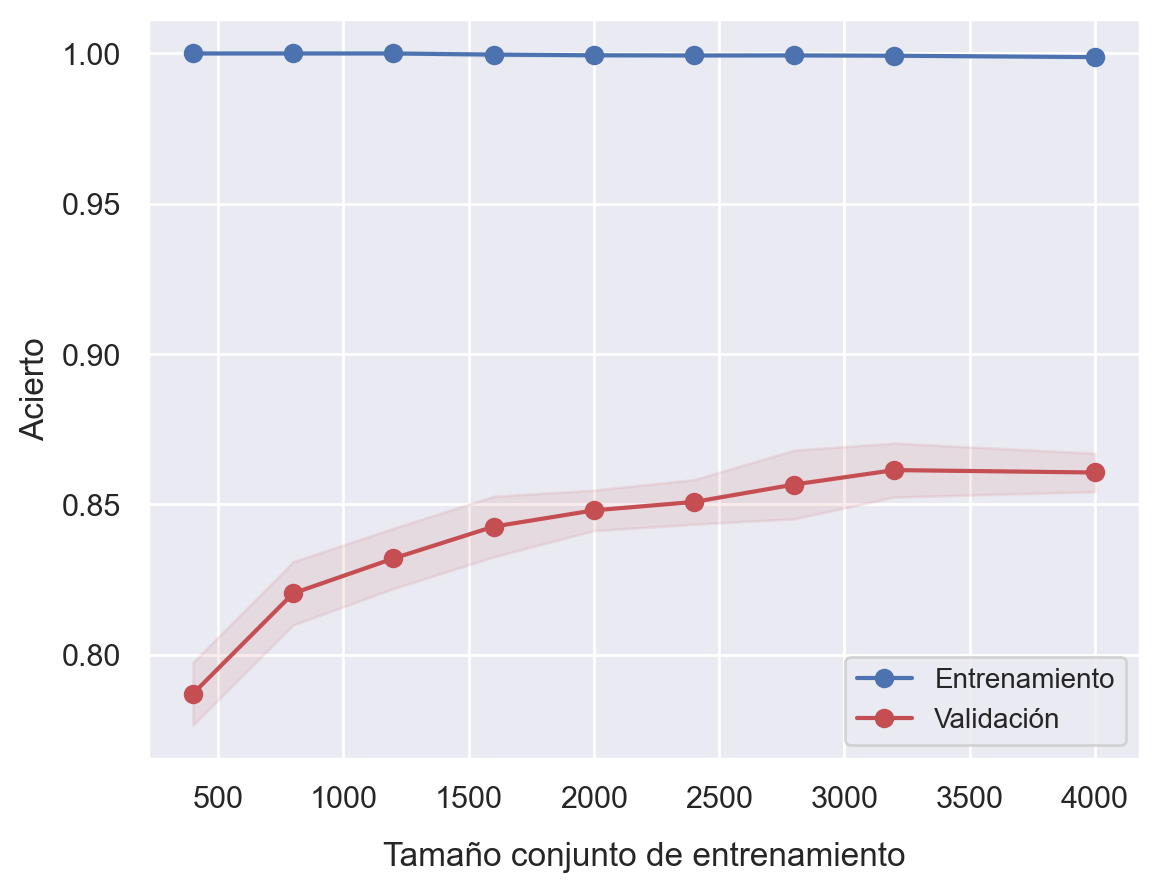

In [21]:
plt.xlabel('Tamaño conjunto de entrenamiento', labelpad=10)
plt.ylabel('Acierto')

plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.1,
                 color='b')

plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.1,
                 color='r')

plt.plot(train_sizes,
         train_scores_mean,
         'o-',
         color='b',
         label='Entrenamiento')
plt.plot(train_sizes,
         test_scores_mean,
         'o-',
         color='r',
         label='Validación')

plt.legend(loc=4, fontsize=10)
plt.show()

# 9. Evaluación del modelo

El rendimiento real del modelo tiene que ser evaluado con datos no utilizados en el proceso de aprendizaje o validación.

La evaluación del rendimiento del modelo anterior, se hará sobre los datos del DataFrame `df_new_reviews`. Para ello, es necesario someter los nuevos comentarios al mismo proceso de limpieza y preprocesamiento. En este último paso, es necesario utilizar el mismo objeto `TfidfVectorizer` creado para el entrenamiento del modelo para producir la matriz de datos `tfidf_test`. Por último, se copiará esa matriz de datos en la variable `X_test`, y se obtendrá los valores del campo `sentiment`, que se almacenará en `y_test`.

In [22]:
df_new_reviews['review'] = df_new_reviews['review'].apply(removeHTML)
df_new_reviews['review'] = df_new_reviews['review'].apply(clean)

tfidf_test = tfidf_vec.transform(df_new_reviews['review'])

X_test = tfidf_test
y_test = df_new_reviews['sentiment'].values

In [23]:
print('Tasa de acierto (Conjunto de test): {}%'.format(lf_model.score(X_test, y_test)*100))

Tasa de acierto (Conjunto de test): 85.18%


Esta es la probabilidad de clasificar correctamente una revisión. Sin embargo, si queremos hacer una estimación global de la tasa de comentarios positivos, y asumiendo que el error se distribuya independientemente de la clase, es posible tener algo más de precisión.

Obtener la matriz de confusión, reportar la proporción de comentarios positivos real en test, y la proporción de comentarios positivos detectada.

In [24]:
y_pred = lf_model.predict(X_test)

cm = confusion_matrix(y_test,
                      y_pred)

prop_real = np.sum(y_test)/len(y_test)
prop_etiq = (cm[0,1] + cm[1,1])/len(y_test)

In [25]:
print('Matriz de confusión: \n\n', cm, '\n')
print('Proporcion de comentarios positivos: %.2f' % prop_real)
print('Proporcion de comentarios etiquetados: %.2f' % prop_etiq)

Matriz de confusión: 

 [[2081  403]
 [ 338 2178]] 

Proporcion de comentarios positivos: 0.50
Proporcion de comentarios etiquetados: 0.52


Ha etiquetado 403 comentarios positivos que son realmente negativos, y 338 negativos que son positivos.

# 10. Extracción de información del modelo

Además de la función de predicción, la regresión logística permite extraer cierta información con respecto al patrón que subyace en los datos. Así, el valor absoluto de un coeficiente $\theta_t$ refleja la importancia de ese coeficiente en la clasificación, de modo que si $\theta_t$ tiene un valor absoluto alto, eso queire decir que el término t es determinante en la clasificación.

La función `TfidfVectorizer.get_feature_names()` devuelve la lista ordenada de términos en el vocabulario del objeto `TfidfVectorizer`. Por tanto, para obtener las palabras tienen más incidencia en la revisiones, se han de obtener los coeficientes con mayor absoluto, y posteriormente extraer los términos de las posiciones correspondientes a esos coeficientes de la lista.

Vamos a obtener, imprimir los 50 términos más relevantes en la clasificación y razonar la respuesta.

In [27]:
coeffs = lf_model.coef_.ravel()
ord_coeffs = np.argsort(np.abs(coeffs))
best_coeffs = ord_coeffs[-50:]

terms = np.asarray(tfidf_vec.get_feature_names_out())
relevant_terms = terms[best_coeffs]

print(relevant_terms)

['laughabl' 'left' 'classic' 'recommend' 'true' 'badli' 'still' 'fantast'
 'reason' 'good' 'noth' 'especi' 'amaz' 'superb' 'fun' 'oh' 'hilari'
 'pointless' 'brilliant' 'disappoint' 'enjoy' 'unless' 'fail' 'unfortun'
 'perfect' 'suppos' 'poor' 'dull' 'effort' 'lack' 'beauti' 'stupid'
 'definit' 'annoy' 'minut' 'poorli' 'favorit' 'well' 'terribl' 'best'
 'wors' 'love' 'also' 'wast' 'excel' 'bore' 'great' 'aw' 'bad' 'worst']


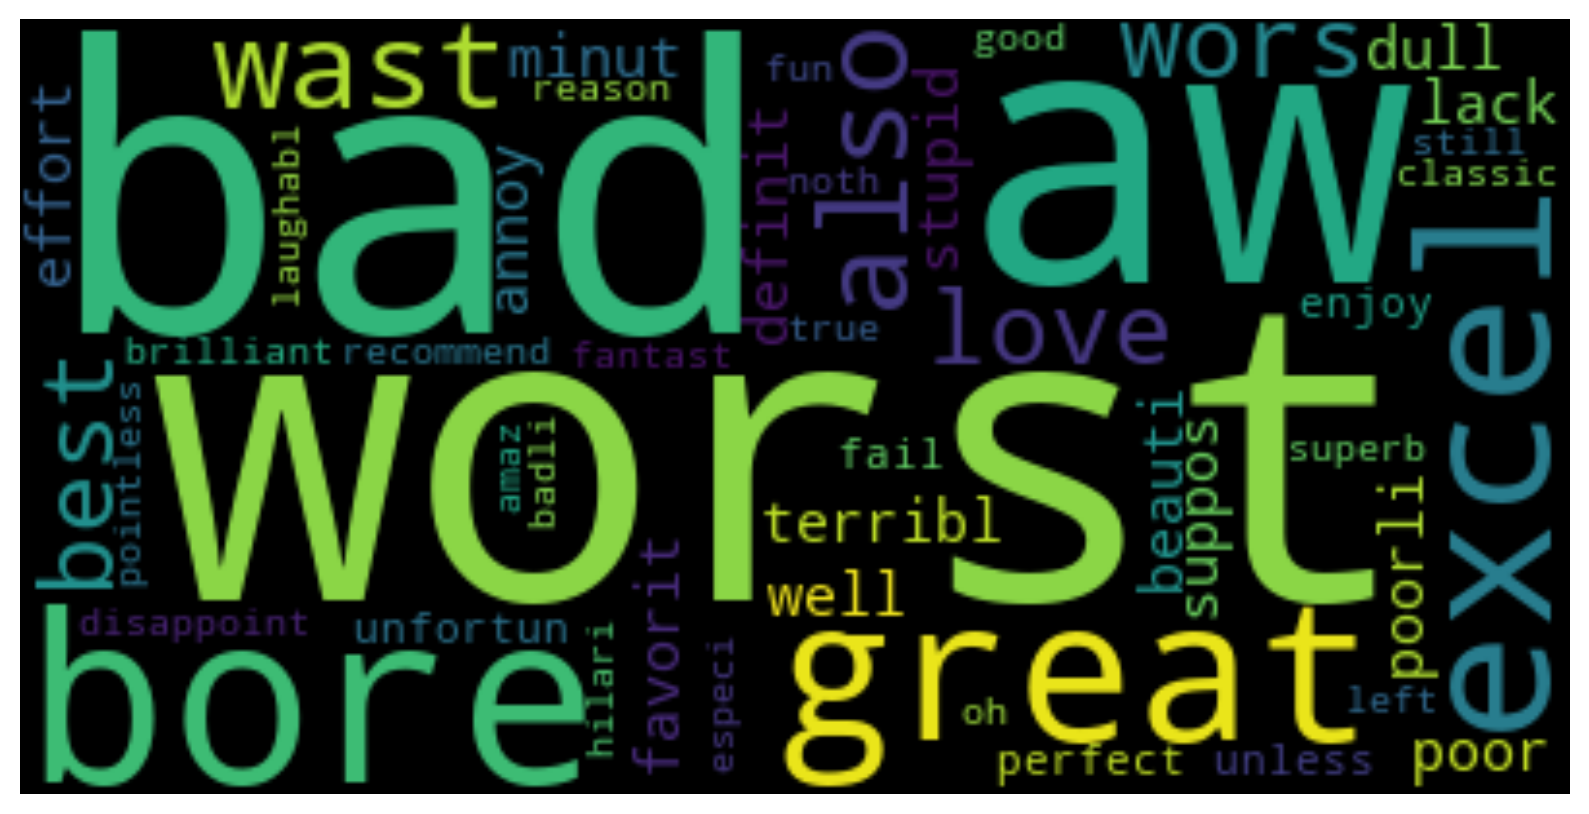

In [31]:
scores = (np.abs(coeffs[best_coeffs]*100)).astype(np.int)
tag_scores = dict(zip(relevant_terms, scores))

wordcloud = WordCloud().generate_from_frequencies(tag_scores)

fig = plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 11. Creación de un modelo simple